# List 5 AoUD
### Authors: Piotr Paduszyński, Michał Kuc 

 ###  Task description
List number 5 was related to text analysis.<br>
Firstly we needed to download a novel from the Project Gutenberg site. <br>
1. Find all cities visited by Phileas Fogg, the protagonist of the novel. <br>
2. Find = use Python code NOT WIKIPEDIA <br>
3. Draw the path of his journey on a world map. <br>
4. Compare the results with Wikipedia and try to find the reason why your <br>
code did not return all of them (you can adjust the code and be more <br>
accurate).
5. Visualize the character mentions per page/chapter
6. Find the top 20 keywords in book/chapter - you can also check the most
popular words in case of part of the speech
7. Visualization sentiment per page/chapter (you can use different algorithms
for sentiment)
8. Visualize graph of co-occurrences (defined as mentions on the same
page).

In [1]:
import re
import requests
import numpy as np
import pandas as pd
from geotext import GeoText
from  bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import itertools
from collections import Counter

import spacy
from spacy.lang.en import English
from spacy import displacy

import spacy
import en_core_web_sm
import string

## Download book 
From the site we downloaded content. Then we created function $\textit{get_titles_and_text} $ which finds all chapter titles 
by getting <br>content from 'h4' parts and chapter texts from 'p' parts. Function returns names and text related to each chapter. <br> Next we created data frame from collected data.

In [2]:
# =============== Get novel from the internet ====================
r = requests.get('http://www.gutenberg.org/files/103/103-h/103-h.htm')
soup = BeautifulSoup(r.content, 'html.parser')
book = soup.find_all(['h4','p']) 

In [3]:
# =============== Function to get titles and text from each chapter ===========
def get_titles_and_text(book,chapters_num):
    chapter_names = []
    chapter_contents = ['']*chapters_num # 37 is number of chapters
    i = -1
    
    for chapter in book:
        if chapter.name == 'h4':
            i += 1
            ch_name = chapter.text.strip() # get text from that part
            ch_name = ch_name.replace("\r\n"," ") 
            chapter_names.append(ch_name)

        if chapter.name == 'p':
            ch_content = chapter.text.strip() # get text from that part
            ch_content = ch_content.replace("\r\n"," ").replace(".",". ") # there are places where there is no indent after dot
            chapter_contents[i] += ch_content # add text till the next chapter
    
    return chapter_names, chapter_contents

In [4]:
# ============== Use function get_titles_and_content ===================
chapters_num = 37
chapter_names, chapter_contents = get_titles_and_text(book,chapters_num)

In [5]:
# ============== Create dataframe whit index, chapter title and chapter text ==============
df = pd.DataFrame(zip(chapter_names,chapter_contents), index = [i+1 for i in range(chapters_num)], columns= ['Chapter title', 'Chapter text'])
df.head(3)

,Chapter title,Chapter text
1,IN WHICH PHILEAS FOGG AND PASSEPARTOUT ACCEPT ...,"Mr. Phileas Fogg lived, in 1872, at No. 7, S..."
2,IN WHICH PASSEPARTOUT IS CONVINCED THAT HE HAS...,"""Faith,"" muttered Passepartout, somewhat flurr..."
3,IN WHICH A CONVERSATION TAKES PLACE WHICH SEEM...,"Phileas Fogg, having shut the door of his hous..."


# Tasks 1 - 4
## Map with visited cities

In [6]:
from geotext import GeoText
import requests
import re
from  bs4 import BeautifulSoup
import time
from geopy.geocoders import Nominatim
import folium
import numpy as np

## Get list of visited cities
To simplify situation we collected text from all chapters with function $\textit{get_book}$. To find cities in text we used GeoText, but there were not "Bombay" and "Calcutta". Because of that we replaced in text "Bombay" to "Mumbai" and "Calcutta" for "Kolkata". There was also problem with "Hong Kong". <br><br>To get list of visited cities we did the steps below
- **From novel text we created TextBlob object, from which we can easily split text into sentences and words;**
- **We searched for the words from key_words which could be related to journey destinations;**
- **If we found in sentence that word, we cheked if there are cities name;**
- **We count how many times each city appears in our list and then we choose those, which had more than 3 occurence**

In [8]:
def get_book(book):
    all_text = ''
    
    for part in book:
        
        if part.name == 'p':
            text = part.text.strip()
            text = text.replace("\r\n"," ").replace(".",". ") # there are places where there is no indent after dot
            all_text += text

    return all_text

In [8]:
all_text = get_book(book)   

In [10]:
from textblob import TextBlob
corpus = all_text
blob_object = TextBlob(corpus)
blob_object = blob_object.replace("Bombay", "Mumbai").replace("Calcutta", "Kolkata")
corpus_sentence = blob_object.sentences

In [12]:
key_words = ['from','arrived','left','reached','visited','reach','passing','departed',
             'abandoned','stayed','stopped','arrival','leave','journey','From','Arrived',
             'Left','Reached','Visited','Reach','Passing',
             'Departed',' Abandoned','Stayed','Stopped']

C = []
visited = []
for ind in range(len(corpus_sentence)):
        se = corpus_sentence[ind] # take sentence after seftenc
        check = any(item in se for item in key_words) # check if there is any word which is also i key_words
        if check == True: # if yes
            se2 = str(se)
            for i in key_words:
                if i in se2:
                    se2 = se2.replace(i,'')

                    
            city = GeoText(se2).cities # get cities names from sentence
            country = GeoText(se2).countries
            if city != []: # if not empty
                visited += city
            if country != []:
                C += country
        else:
            pass
# C

In [13]:
wordcount_counter=Counter(visited) 
wordcount_counter
Country = Counter(C) 
C = [k for k,v in dict(Country).items() if v>5]
C

['India', 'Mongolia', 'Singapore', 'Hong Kong', 'Japan', 'China']

## Why it does not work properly?
We see that we have some results which we expected like 'Hong Kong' or 'Singapore', but we also have wrong countries like 'Mongolia' or 'China'  <br> which are names of ships they travelled. Because of that we cannot append them to our created further map.

In [18]:
cities = [k for k,v in dict(wordcount_counter).items() if v>1]
# # Fort Kearney -> Newark
# cities.append('Singapore')
print(cities)
# Allahabad
# Singapur 
# Hong Kong
# Medicie Bow
# Fort Kearney

['London', 'Suez', 'Brindisi', 'Aden', 'Mumbai', 'Paris', 'Turin', 'Kolkata', 'Yokohama', 'San Francisco', 'New York', 'Shanghai', 'Liverpool', 'Omaha', 'Salt Lake', 'Sacramento', 'Missouri', 'Ogden', 'Sioux', 'Chicago', 'Hudson', 'Dublin']


### Draw a map
To draw our results on a map we needed cities location. We used geolocator for each city. That allowed us to have latitudes and logitudes. <br>
Next step is to plot cities location on the map.

In [19]:
from geopy.geocoders import Nominatim
chrome_user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36"
geolocator = Nominatim(timeout=10, user_agent=chrome_user_agent)

positions = {}

for city in cities:
    
    try: 
        position = geolocator.geocode(city)
    except:
        pass
        
    if position:
        location = [position.latitude, position.longitude]
        positions.update({city:location})
        del position
        
    else:
        print("Problem to get location of city {}".format(city))

print(positions)

{'London': [51.5073219, -0.1276474], 'Suez': [29.974498, 32.537086], 'Brindisi': [40.6362271, 17.688500723698695], 'Aden': [12.789585, 45.028504], 'Mumbai': [19.0759899, 72.8773928], 'Paris': [48.8566969, 2.3514616], 'Turin': [45.0677551, 7.6824892], 'Kolkata': [22.5414185, 88.35769124388872], 'Yokohama': [35.444991, 139.636768], 'San Francisco': [37.7790262, -122.4199061], 'New York': [40.7127281, -74.0060152], 'Shanghai': [31.2322758, 121.4692071], 'Liverpool': [53.407154, -2.991665], 'Omaha': [41.2587459, -95.9383758], 'Salt Lake': [40.6632297, -111.9103124], 'Sacramento': [38.5810606, -121.4938951], 'Missouri': [38.7604815, -92.5617875], 'Ogden': [41.2230048, -111.9738429], 'Sioux': [43.0574079, -96.1602368], 'Chicago': [41.8755616, -87.6244212], 'Hudson': [42.7654433, -71.4397167], 'Dublin': [53.3497645, -6.2602732]}


In [20]:
mapa = folium.Map(location=[0,0], zoom_start=2)

for city, location in positions.items():
    mapa.add_child(folium.Marker(location=location, popup=folium.Popup(city), icon=folium.Icon(color='green',icon='info-sign')))
    
locations = [v for k,v in positions.items()]
loc_sort = sorted(locations, key = lambda x: x[1])
folium.PolyLine(loc_sort, color="blue", weight=2.5, opacity=1).add_to(mapa)
  
mapa

In [26]:
cities_we_found = ['London', 'Suez', 'Brindisi', 'Aden', 'Mumbai', 'Paris', 'Turin', 'Kolkata', 'Yokohama', 'San Francisco',
                'New York', 'Shanghai', 'Liverpool', 'Omaha', 'Salt Lake', 'Sacramento', 'Missouri', 'Ogden', 
                  'Sioux', 'Chicago', 'Hudson', 'Dublin']

cities_in_book = ['London', 'Suez', 'Brindisi', 'Aden', 'Mumbai', 'Paris', 'Turin', 'Kolkata', 'Yokohama', 'San Francisco', 
                  'New York', 'Shanghai', 'Liverpool', 'Omaha', 'Salt Lake','Allahabad', 
                 'Chicago', 'Dublin','Singapore','Hong Kong','Medicine Bow','Fort Kearney','Queenstown']
set(cities_we_found) - set(cities_in_book)

{'Hudson', 'Missouri', 'Ogden', 'Sacramento', 'Sioux'}

## Why there is a difference? (1)
There are cities which characters could mentioned or they drived through these cities. We think that amount of wrong results is a natural thing.

In [27]:
set(cities_in_book) - set(cities_we_found)

{'Allahabad',
 'Fort Kearney',
 'Hong Kong',
 'Medicine Bow',
 'Queenstown',
 'Singapore'}

## Why there is a difference? (2)
We see what cities we expected to find, but because of few things we could not do that. One of them is mentioned problem about <br> 'Hong Kong' and 'Singapore'. For the rest there was problem with our method. GeoText could not find them or even found <br> city with the same name but different location ('Queenstown' in New Zealand, not in Ireland).

# Task  6 (extended version)

In [7]:
nlp1 = en_core_web_sm.load()

Below we created different functions. <br>
- **$\textit{get_words_from_chapter}$** let us get not only text splitted to words, punctuations, but also show us dictionary form of each word. Information about each word/sign wil be putted into data framme. <br><br>
- **$\textit{Words_in_chapters}$** returns words for each chapter, we rejected stop words and took only lemma column. We made a dictionary where there is word and number of its uses. Function returns data frame with most used word. <br><br>

- **$\textit{sum_in_chapter}$** tells us how many words of choosen part of speech there are in chapter.<br><br>
- **$\textit{most_frequent_part_chapter}$** is a modification of previous function. It returns also most frequent words from choosen part of speech. For example we can search for most used nouns in chapter.


In [16]:
##### MOST POPULAR WORDS IN BOOK #####
def get_words_from_chapter(doc):
    
    col = ["text", "lemma", "pos", "is_alpha", "is_stop","is_upper","is_punct"]
    example_df = pd.DataFrame([],columns = col) # empty data frame, only with column names
    
    for token in doc: # for every token in text
        d = pd.DataFrame([[token.text, token.lemma_, token.pos_, token.is_alpha, token.is_stop,token.is_upper,token.is_punct]],columns=col)
        example_df = pd.concat([example_df,d]) # data frames concatenation
        
    return example_df

def Words_in_chapters(chapterS,chapterF,number):
    text  = ''
    for i in range(chapterS,chapterF+1):
        text = text + df['Chapter text'][i]
    doc = nlp1(text)
    df2 = get_words_from_chapter(doc) 
    df2 = df2.loc[(df2['is_alpha']==True) & (df2['is_stop']==False)] # reject stop words and is_alpha
    words = list(df2['lemma'])
    wordcount_counter=Counter(words) # dictionary, for each word there is number of its use
    w = [i[0] for i in wordcount_counter.most_common(number)]
    q = [i[1] for i in wordcount_counter.most_common(number)]
    example_df = pd.DataFrame([],columns = [])
    example_df.insert(0,'word',w)
    example_df.insert(1,'quantity',q)
    d = pd.DataFrame([],columns = ['word','quantity'])
    d = pd.concat([d,example_df]) 
        
    return d   

def sum_in_chapter(part_of_speech,chapter):
    
    doc = nlp1(df['Chapter text'][chapter])
    df2 = get_words_from_chapter(doc)
    df2 = df2.loc[(df2['is_alpha']==True) & (df2['is_stop']==False)]

    if part_of_speech == 'adjective':
        df2 = df2.loc[(df2['pos']=='ADJ')]
    elif part_of_speech == 'adverb':
        df2 = df2.loc[(df2['pos']=='ADV')]
    elif part_of_speech == 'noun':
        df2 = df2.loc[(df2['pos']=='NOUN') | (df2['pos']=='PRON') | (df2['pos']=='PROPN')]
    elif part_of_speech == 'verb':
        df2 =  df2.loc[(df2['pos']=='VERB') | (df2['pos']=='AUX')]
    
    return len(df2)

def most_frequent_part_chapter(part_of_speech,chapter,number):
    doc = nlp1(df['Chapter text'][chapter])
    df2 = get_words_from_chapter(doc)
    df2 = df2.loc[(df2['is_alpha']==True) & (df2['is_stop']==False)]
    if part_of_speech == 'adjective':
        df2 = df2.loc[(df2['pos']=='ADJ')]
    elif part_of_speech == 'adverb':
        df2 = df2.loc[(df2['pos']=='ADV')]
    elif part_of_speech == 'noun':
        df2 = df2.loc[(df2['pos']=='NOUN') | (df2['pos']=='PRON') | (df2['pos']=='PROPN')]
    elif part_of_speech == 'verb':
        df2 =  df2.loc[(df2['pos']=='VERB') | (df2['pos']=='AUX')]
       
    words = list(df2['lemma'])
    wordcount_counter=Counter(words)
    w = [i[0] for i in wordcount_counter.most_common(number)]
    q = [i[1] for i in wordcount_counter.most_common(number)]
    example_df = pd.DataFrame([],columns = [])
    example_df.insert(0,'word',w)
    example_df.insert(1,'quantity',q)
    d = pd.DataFrame([],columns = ['word','quantity'])
    d = pd.concat([d,example_df]) 
    return d

In [17]:
### TOP 20 WORDS IN THE BOOK ###
Words_in_chapters(1,37,20)      

,word,quantity
0,Fogg,601
1,Passepartout,349
2,Phileas,211
3,Fix,211
4,say,204
5,day,157
6,go,145
7,hour,145
8,time,142
9,train,138


In [18]:
### TOP 10 WORDS FOR CHOSEN CHAPTERS ###
chapters = [1,10,20]
for i in chapters:
    print('Top words in chapter ' + str(i))
    db = Words_in_chapters(i,i,10)
    print(db.to_string(index=False))

Top words in chapter 1
     word quantity
     Fogg       17
  Phileas       12
     know        7
  Saville        6
      Row        6
     live        5
   member        5
     club        5
       go        5
 monsieur        5
Top words in chapter 10
     word quantity
   Bombay       12
     Fogg       10
    India        9
 Calcutta        7
    leave        7
  station        6
       go        6
      Fix        6
     time        5
      far        5
Top words in chapter 20
     word quantity
     Fogg       26
    Aouda       12
      Fix       12
    pilot        9
 Yokohama        8
      say        8
     boat        8
     hour        7
  steamer        6
 Carnatic        6


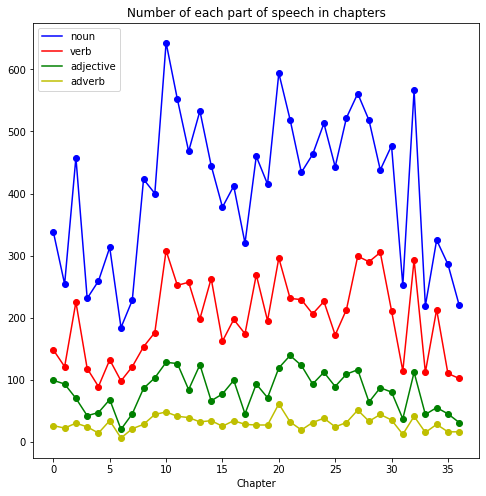

In [19]:
##### NUMBER OF EACH PART OF SPEECH #####
speech = ['noun','verb','adjective','adverb']
RESULTS = []
for part in speech:
    Result = []
    for i in range(1,38):
        Result.append(sum_in_chapter(part,i))
    RESULTS.append(Result)
    
plt.figure(figsize = (8,8))
plt.plot(RESULTS[0],'b',label = 'noun')
plt.plot(RESULTS[1],'r',label = 'verb')
plt.plot(RESULTS[2],'g',label = 'adjective')
plt.plot(RESULTS[3],'y',label = 'adverb')
plt.plot(RESULTS[0],'bo')
plt.plot(RESULTS[1],'ro')
plt.plot(RESULTS[2],'go')
plt.plot(RESULTS[3],'yo')
plt.title('Number of each part of speech in chapters')
plt.xlabel('Chapter')
plt.legend()
plt.show()

In [20]:
##### MOST POPULAR PART OF SPEECH IN CHOSEN CHAPTERS #####
speech = ['noun','verb','adjective','adverb']
chapters = [1,10,20]
for i in chapters:
    print('CHAPTER ' + str(i))
    for part in speech:
        db = most_frequent_part_chapter(part,i,1)
        print('Most popular ' + part + ' is:',db.iloc[0,0], db.iloc[0,1])

CHAPTER 1
Most popular noun is: Fogg 17
Most popular verb is: know 7
Most popular adjective is: good 3
Most popular adverb is: certainly 3
CHAPTER 10
Most popular noun is: Bombay 12
Most popular verb is: leave 7
Most popular adjective is: native 4
Most popular adverb is: far 5
CHAPTER 20
Most popular noun is: Fogg 26
Most popular verb is: say 8
Most popular adjective is: little 3
Most popular adverb is: far 2


## Task 7 (sentiment per chapter)
First we use NLP to tokenize text into sentences.  

In [21]:
nlp2 = English()
nlp2.add_pipe(nlp2.create_pipe('sentencizer'))

In [22]:
def sentence_tokinization(text):
    my_doc = nlp2(text)
    # create list of sentence tokens
    return [sent_token.text.strip() for sent_token in my_doc.sents]

In [23]:
df["Sentences"] = df["Chapter text"].apply(sentence_tokinization)

In [24]:
df.head(3)

,Chapter title,Chapter text,Sentences
1,IN WHICH PHILEAS FOGG AND PASSEPARTOUT ACCEPT ...,"Mr. Phileas Fogg lived, in 1872, at No. 7, S...","[Mr. Phileas Fogg lived, in 1872, at No., 7, ..."
2,IN WHICH PASSEPARTOUT IS CONVINCED THAT HE HAS...,"""Faith,"" muttered Passepartout, somewhat flurr...","[""Faith,"" muttered Passepartout, somewhat flur..."
3,IN WHICH A CONVERSATION TAKES PLACE WHICH SEEM...,"Phileas Fogg, having shut the door of his hous...","[Phileas Fogg, having shut the door of his hou..."


In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def sentiment_scores(sentence): 
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    return sentiment_dict

- **$\textit{chapters_sentiment}$** function takes sentences from each chapter and counts mean value of sentiment (positive,neutral or negtive). 

In [26]:
def chapters_sentiment(df_sentences,chapters_num):
    NEG = []
    NEU = []
    POS = []
    COMP = []
    
    for i in range(1,chapters_num+1):
        sentences = df_sentences[i]
        
        neg = []
        neu = []
        pos = []
        comp = []
        
        for j in range(len(sentences)):
            
            d = sentiment_scores(sentences[j])
            neg.append(d['neg'])
            neu.append(d['neu'])
            pos.append(d['pos'])
            comp.append(d['compound'])
            
        NEG.append(np.mean(neg))
        NEU.append(np.mean(neu))
        POS.append(np.mean(pos))
        COMP.append(np.mean(comp))
    return NEG,NEU,POS,COMP

In [27]:
chapters_num = 37
NEG,NEU,POS,COMP = chapters_sentiment(df["Sentences"],chapters_num)

### Description to the plot below
<span style='color:Red'>Red </span> is mean value of negative sentiment from all sentences from chapter <br>
<span style='color:Blue'>Blue </span> is mean value of neutral sentiment <br>
<span style='color:Green'>Green </span> Blue is mean value of postivie sentiment <br>
Above ech bar there is mean compund value.

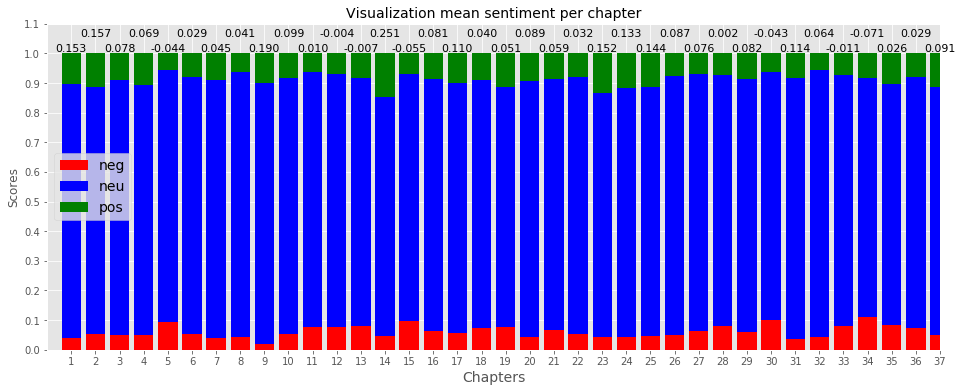

In [28]:
neg, neu, pos, compound = NEG, NEU, POS, COMP
level = [sum(x) for x in zip(neg, neu)]
ind = [i for i in range(1,len(NEG)+1)]

plt.style.use('ggplot')
fig = plt.figure(figsize=(16,6))
ax = plt.subplot(111)

p1 = plt.bar(ind,neg, color='red')
p2 = plt.bar(ind, neu, bottom=neg, color='blue')
p3 = plt.bar(ind, pos, bottom=level, color='green')  

for en,rect in enumerate(p3):
#     print(rect.get_x() + rect.get_width()/2.0)

    if en%2 == 0:
        height = 1
    else:
        height = 1.05
    
    plt.text(en+1, height,  "%.3f" % compound[en], ha='center', va='bottom',fontsize=11)

plt.ylabel('Scores')
plt.xlabel('Chapters',fontsize=14)
plt.title('Visualization mean sentiment per chapter',fontsize=14)    
    
plt.xlim([0,23])
plt.xticks(ind, range(1,len(NEG)+1))
plt.yticks(np.arange(0, 1.2,0.1))
plt.legend((p1[0], p2[0],p3[0]), ('neg', 'neu','pos'),fontsize=14,loc=6)
ax.yaxis.grid(True)
plt.show()

## Task 7 (sentiment per page)

In [9]:
from textblob import TextBlob
all_text = get_book(book) 
corpus = all_text
blob_object = TextBlob(corpus)
corpus_sentence = blob_object.sentences

### How we get pages from the book
To split book into pages we assumed that each page has about 250 words. First we tokenized text into sentences and then we found sentences in which there is 250th, 500th, 750th, ... word. Then we saved indexes of that sentences and split our book into pages. Next page starts when last sentence on page has ended.

In [10]:
# List 'I' contains indexes of sentences where algrithm found 250th word.
# To all indexes we add 1, because python dont take last element in range.
# Lets assume that we want to take 3 first sentences, which have indexes 0,1,2
# To take them we need to choose sentences[0:3].
# That's why we add 1.

def get_sentences_for_each_page(words_on_page):
    words_num = 0
    I = []
    for ind in range(len(corpus_sentence)):
        se = corpus_sentence[ind]
        words_num += len(se.words)

        if words_num < words_on_page:
            pass

        else:
            I.append(ind+1)
            words_num = 0

    I.insert(0,0) #At the beginning of the list we add '0'.


    df2 = pd.DataFrame([],columns = ['page','text'])
    for i in range(len(I)-1): 

        page = [str(se) for se in corpus_sentence[I[i]:I[i+1]]] # sentences with indexes from I[i] to I[i+1]
        df2.loc[i+1] = [i+1,page] # put it into data frame
    df2.loc[len(I)] = [len(I),[str(se) for se in corpus_sentence[I[len(I)-1]:]]] # last page   
   
    return df2

In [11]:
words_on_page = 250
d = get_sentences_for_each_page(words_on_page)
d.tail()

,page,text
234,234,"[""The clock indicated eighteen minutes to nine..."
235,235,"[Passepartout went on his errand enchanted., H..."
236,236,[How came he to think that he had arrived in L...
237,237,[He divided the one thousand pounds that remai...
238,238,"[Phileas Fogg had won his wager, and had made ..."


In [37]:
NEG,NEU,POS,COMP = chapters_sentiment(d["text"],238)

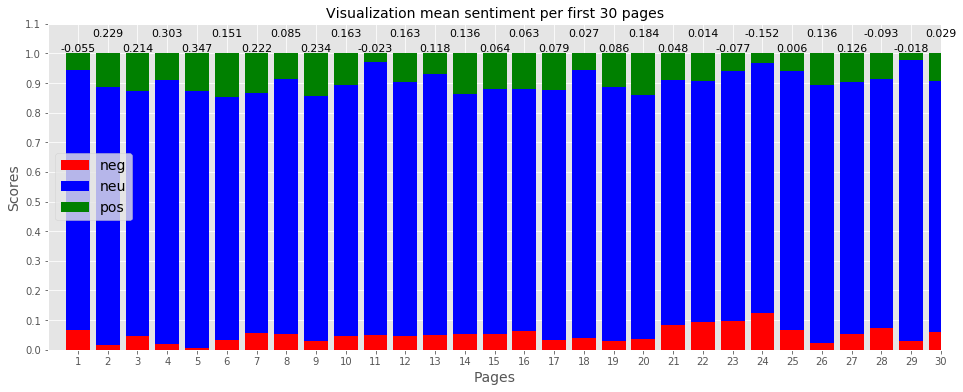

In [38]:
neg, neu, pos, compound = NEG[:30], NEU[:30], POS[:30], COMP[:30]
level = [sum(x) for x in zip(neg, neu)]
ind = [i for i in range(1,len(neg)+1)]

plt.style.use('ggplot')
fig = plt.figure(figsize=(16,6))
ax = plt.subplot(111)

p1 = plt.bar(ind,neg, color='red')
p2 = plt.bar(ind, neu, bottom=neg, color='blue')
p3 = plt.bar(ind, pos, bottom=level, color='green')  

for en,rect in enumerate(p3):

    if en%2 == 0:
        height = 1
    else:
        height = 1.05
    
    plt.text(en+1, height,  "%.3f" % compound[en], ha='center', va='bottom',fontsize=11)

plt.ylabel('Scores',fontsize=14)
plt.xlabel('Pages',fontsize=14)
plt.title('Visualization mean sentiment per first 30 pages',fontsize=14)    
    
plt.xlim([0,23])
plt.xticks(ind, range(1,len(neg)+1))
plt.yticks(np.arange(0, 1.2,0.1))
plt.legend((p1[0], p2[0],p3[0]), ('neg', 'neu','pos'),fontsize=14,loc=6)
ax.yaxis.grid(True)
plt.show()

## Task 5 (mentions per chapter)

In [32]:
def find_persons(text):
    
     # Create Doc object
    doc2 = nlp1(text)

     # Identify the persons
    persons = [ent.text for ent in doc2.ents if ent.label_ == 'PERSON']

     # Return persons
    return persons
persons = find_persons(df['Chapter text'][3])

In [33]:
persons = []
for chap in range(1,37+1):
    x = find_persons(df['Chapter text'][chap])
    x = [i for i in x if ' ' in i]
    persons.extend(x)

# persons

In [34]:
p = [i for i in persons if '.' not in i and '?' not in i and "'s" not in i and '—' not in i]
persons_counter=Counter(p)
x = [i for i in persons_counter]
persons_counter

Counter({'Saville Row': 10,
         'James Forster': 3,
         'Jean Passepartout': 1,
         'Angelica Kauffmann': 1,
         'Andrew Stuart': 9,
         'John Sullivan': 5,
         'Samuel Fallentin': 3,
         'Thomas Flanagan': 7,
         'Gauthier Ralph': 4,
         'Phileas Fogg': 7,
         'Mont Cenis': 1,
         'Left Turin': 1,
         'Decimus Smith': 1,
         'Francis Cromarty': 13,
         'Ucaf Uddaul': 1,
         'Lord Cornwallis': 1,
         'Jametsee Jeejeebhoy': 1,
         'John Bunsby': 14,
         'WILLIAM BATULCAR': 1,
         'John Busby': 1,
         'William Hitch': 3,
         'Joe Smith': 1,
         'Joseph Smith': 2,
         'Elder Hitch': 1,
         'mummy showman': 1,
         'Brigham Young': 2,
         'Victor Hugo': 1,
         'Stamp Proctor': 4,
         'Laramie Peak': 1,
         'Medicine Bow': 4,
         'Cheyne Pass': 1,
         'Evans Pass': 1,
         'Fort McPherson': 1,
         'John Bull': 1,
         'Saint J

## Problem with person finder function
In our list with found characters we have few wrong results such as 'Medicine Bow' which is name of the city or 'Saville Row' which is name of the street. <br> We cannot rely on that function, so in the next step we created list with well known characters
from the novel.

In [35]:
characters = ['Fogg','Passepartout','Fix','Aouda','Cromarty','Bunsby','Proctor',
              'Camerfield','Mandiboy','Hitch','Speedy']

In [36]:
from textblob import TextBlob

In [64]:
def mentions_chapter(df,who):
    mentions_per_chapter = []
    for i in range(1,38):
        text = df['Chapter text'][i]
        corpus = text
        blob_object = TextBlob(corpus)
        words = blob_object.words

        mentions = []
        for word in words:
            if word in characters:
                mentions.append(word)
        word_counter = Counter(mentions)
        word_counter = dict(word_counter)
        x = [item[0] for item in word_counter.items()]
#         print(x)
        if who in x:
            mentions_per_chapter.append(word_counter[who])
        else:
            mentions_per_chapter.append(0) 
    return mentions_per_chapter

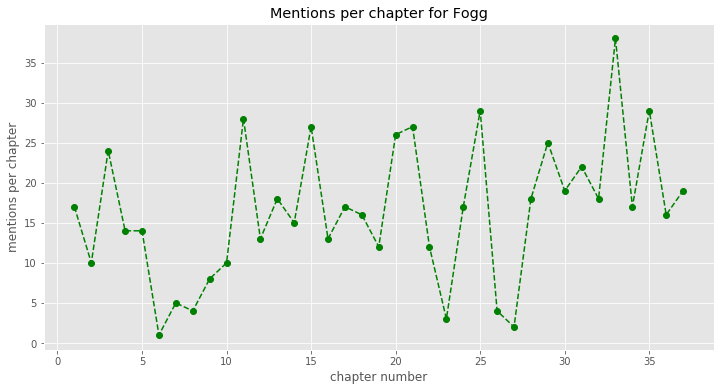

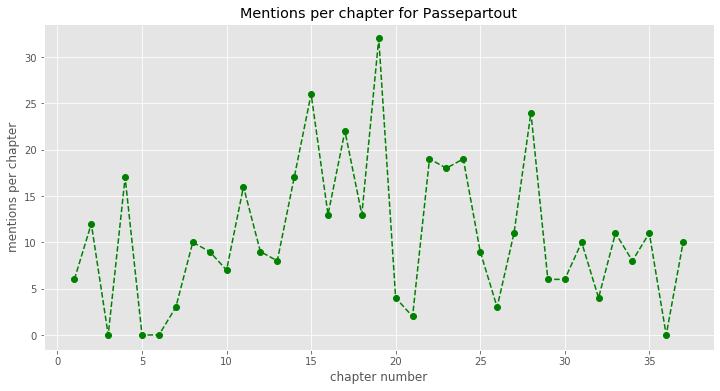

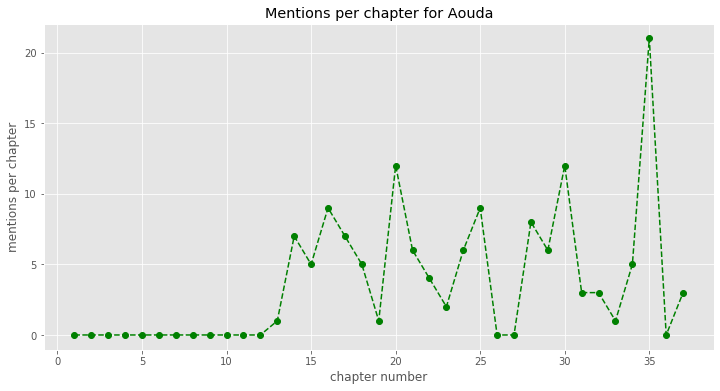

In [105]:
x = [i for i in range(1,38)]
W = ['Fogg','Passepartout','Aouda']
for who in W:
#     who = 'Fogg'
    mentions_per_chapter = mentions_chapter(df,who)


    plt.style.use('ggplot')
    fig = plt.figure(figsize=(12,6))
    plt.plot(x,mentions_per_chapter, 'go')
    plt.plot(x,mentions_per_chapter, 'g--')
    plt.xlabel('chapter number')
    plt.ylabel('mentions per chapter')
    plt.title('Mentions per chapter for '+str(who))
    plt.show()

## Task 5 (mentions per page)

In [12]:
############### Mentions per page ############################
all_text = get_book(book) 
corpus = all_text
blob_object = TextBlob(corpus)
corpus_sentence = blob_object.sentences

In [13]:
words_on_page = 250
d = get_sentences_for_each_page(words_on_page)
d.tail()
# d['text'][238]

,page,text
234,234,"[""The clock indicated eighteen minutes to nine..."
235,235,"[Passepartout went on his errand enchanted., H..."
236,236,[How came he to think that he had arrived in L...
237,237,[He divided the one thousand pounds that remai...
238,238,"[Phileas Fogg had won his wager, and had made ..."


In [49]:
def mentions_page(d,who):
    mentions_per_page = []
    for i in range(1,239):
        corpus = ''
        for t in d['text'][i]:
            corpus = corpus+t

        blob_object = TextBlob(corpus)
        words = blob_object.words
        mentions = []
        for word in words:
            if word in characters:
                mentions.append(word)
        word_counter = Counter(mentions)
        word_counter = dict(word_counter)
        x = [item[0] for item in word_counter.items()]

        if who in x:
            mentions_per_page.append(word_counter[who])
        else:
            mentions_per_page.append(0) 
    return mentions_per_page


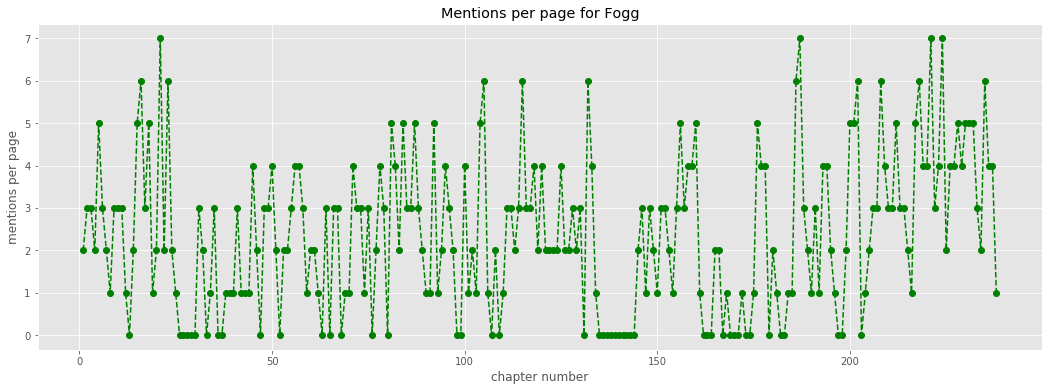

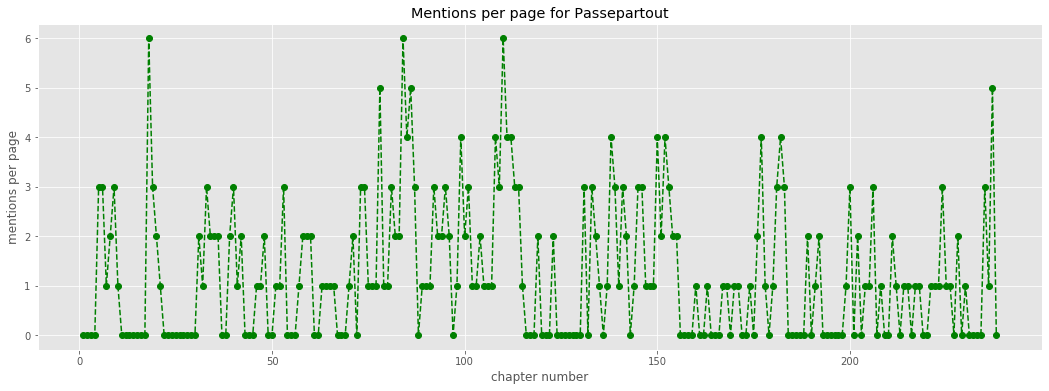

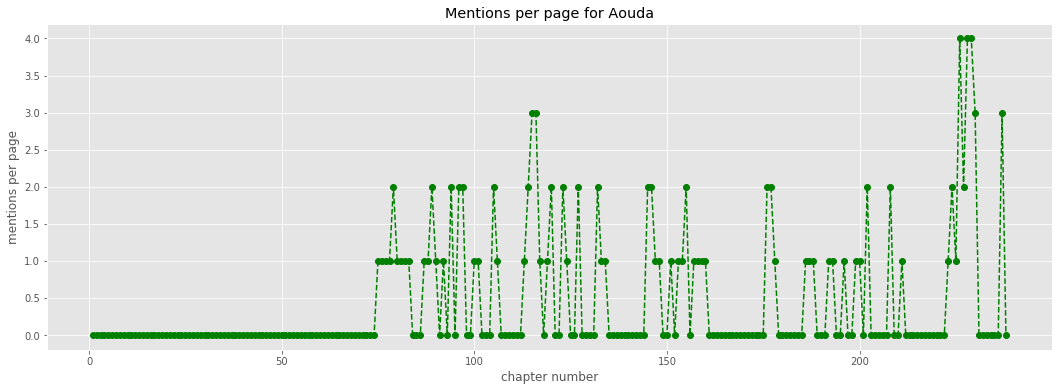

In [50]:
x = [i for i in range(1,239)]
W = ['Fogg','Passepartout','Aouda']
for who in W:
    
# who = 'Fogg'
    mentions_per_page = mentions_page(d,who)


    plt.style.use('ggplot')
    fig = plt.figure(figsize=(18,6))
    plt.plot(x,mentions_per_page, 'go')
    plt.plot(x,mentions_per_page, 'g--')
    plt.xlabel('chapter number')
    plt.ylabel('mentions per page')
    plt.title('Mentions per page for '+str(who))
    plt.show()

In [17]:
#import networkx as nx
d['text'][1]

['Mr.  Phileas Fogg lived, in 1872, at No.',
 '7, Saville Row, Burlington Gardens, the house in which Sheridan died in 1814.',
 'He was one of the most noticeable members of the Reform Club, though he seemed always to avoid attracting attention; an enigmatical personage, about whom little was known, except that he was a polished man of the world.',
 'People said that he resembled Byron—at least that his head was Byronic; but he was a bearded, tranquil Byron, who might live on a thousand years without growing old.',
 'Certainly an Englishman, it was more doubtful whether Phileas Fogg was a Londoner.',
 'He was never seen on \'Change, nor at the Bank, nor in the counting-rooms of the "City"; no ships ever came into London docks of which he was the owner; he had no public employment; he had never been entered at any of the Inns of Court, either at the Temple, or Lincoln\'s Inn, or Gray\'s Inn; nor had his voice ever resounded in the Court of Chancery, or in the Exchequer, or the Queen\'s 

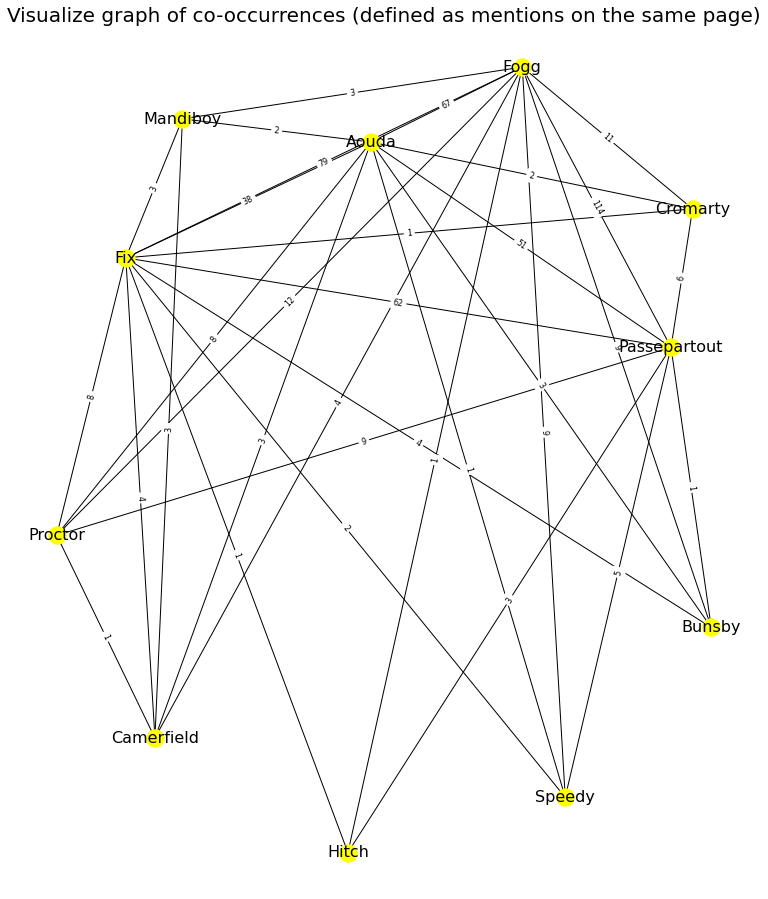

In [39]:
characters = ['Fogg','Passepartout','Fix','Aouda','Cromarty','Bunsby','Proctor',
              'Camerfield','Mandiboy','Hitch','Speedy']
Connections = nx.Graph()

for page in range(1,239):
    characters_on_page = []
    corpus = ''
    
    ## get characters from each page
    for t in d['text'][page]:
        corpus = corpus+t
    blob_object = TextBlob(corpus)
    words = blob_object.words
    for word in words:
        if word in characters:
            if word not in characters_on_page:
                characters_on_page.append(word)
    
    ## increase connection between all characters from each page
    for i in range(len(characters_on_page)):
        for j in range(i+1,len(characters_on_page)):
            if Connections.has_edge(characters_on_page[i],characters_on_page[j]):
                Connections[characters_on_page[i]][characters_on_page[j]]['weight'] = Connections[characters_on_page[i]][characters_on_page[j]]['weight'] + 1
            else:
                Connections.add_edge(characters_on_page[i],characters_on_page[j],weight = 1)            

fig=plt.gcf()
fig.set_size_inches(10,12)
       
pos = nx.spring_layout(Connections,k = 11)
nx.draw(Connections, pos, with_labels = True, font_size=16, edge_color='black',node_color = 'yellow')
weights = nx.get_edge_attributes(Connections,'weight')
nx.draw_networkx_edge_labels(Connections, pos, edge_labels = weights, font_size = 8)

plt.title('Visualize graph of co-occurrences (defined as mentions on the same page)', fontdict = {'fontsize' : 20})
plt.show()